**Autor: Mariana Chaves**
 
**Date: July 2022**

In this notebook we train a [BERT](https://arxiv.org/abs/1810.04805) model to classify movie characters according to their gender based on their dialogues. 
That is, each sample contains all utterances on the character.

**This notebook has mostly didactic purposes.** We explain each step to train the model. In the notebook ```BERT_models.ipynb``` you can find a more compact version of this code, and you can see more results related to the cornell corpus. 

The BERT family of models uses the Transformer encoder architecture to process each token of input text in the full context of all tokens before and after, hence the name: Bidirectional Encoder Representations from Transformers. BERT models are usually pre-trained on a large corpus of text, then fine-tuned for specific tasks. This the approach taken in this notebook. 

This notebook is largely inspired on a [tensorflow tutorial](https://www.tensorflow.org/text/tutorials/classify_text_with_bert). 

## Setup


In [ ]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U "tensorflow-text==2.8.*"

You will use the AdamW optimizer from [tensorflow/models](https://github.com/tensorflow/models).

In [ ]:
!pip install -q tf-models-official==2.7.0

In [ ]:
import os
import shutil
import pandas as pd
import numpy as np
import gensim
from sklearn.model_selection import train_test_split
import time
import pickle

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

## Load data

We use the preprocessed version of the Cornell dataset 

In [ ]:
%cd ..

c:\Users\Dell\Documents\UCA DSAI\Internship 2\Code\text-models


In [ ]:
data = pd.read_csv('datasets/cornell_corpus/cornell_prepro_characters.csv')
data

,Unnamed: 0,characterID,movieID,character_name,gender,movie_title,movie_year,text_with_punctuation,text
0,0,u0,m0,BIANCA,F,10 things i hate about you,1999,They do not! I hope so. Let's go. Okay you're ...,They do not I hope so Lets go Okay youre gonna...
1,1,u100,m6,AMY,F,8mm,1999,She died in her sleep three days ago. It was i...,She died in her sleep three days ago It was in...
2,2,u1001,m65,PETE,M,from dusk till dawn,1996,Six-fifty. Knock yourself out. That's all that...,Sixfifty Knock yourself out Thats all thats be...
3,3,u1007,m66,BLONDELL,F,g.i. jane,1997,Wow Uh don't see it. There's no signature. But...,Wow Uh dont see it Theres no signature But han...
4,4,u1008,m66,C.O.,M,g.i. jane,1997,"Of course, but there's more Uh, V.I.P. securit...",Of course but theres more Uh VIP security arra...
...,...,...,...,...,...,...,...,...,...
2399,2399,u983,m64,ALICE,F,friday the 13th,2009,Maybe we should wait for Mr. Christy. The kill...,Maybe we should wait for Mr Christy The killer...
2400,2400,u985,m64,BILL,M,friday the 13th,2009,It's over twenty miles to the crossroads. Stev...,Its over twenty miles to the crossroads Stevel...
2401,2401,u989,m64,MARCIE,F,friday the 13th,2009,Gotta pee. You're lying on my bladder. Like wa...,Gotta pee Youre lying on my bladder Like waves...
2402,2402,u993,m64,STEVE,M,friday the 13th,2009,I've got to go to town and pick up the trailer...,Ive got to go to town and pick up the trailer ...


We load our word2vec model to extract its vocabulary. 
Then we remove from the text all words that do not belong the vocabulary. 

In [ ]:
# Load word2vec trained model
w2v = gensim.models.KeyedVectors.load("results/cornell_prepro.wordvectors", mmap='r')

# word2vec vocabulary
w2v_vocabulary = list(w2v.vocab.keys())
print('Words in the vocabulary:',len(w2v_vocabulary))

Words in the vocabulary: 11270


In [ ]:
# Sentences to lists of words
docs = [d.lower().split() for d in data['text']]

# Keep only the words that are in the w2v vocabulary (These were the words that appeared 5 times or more times)
docs = [[word for word in doc if word in w2v_vocabulary] for doc in docs]

# Join the list of strings into sentences
docs = [' '.join(doc) for doc in docs]
docs[0:3]

['they do not i hope so lets go okay youre gonna need to learn how to lie im kidding you know how sometimes you just become this and you dont know how to quit like my fear of wearing what good stuff me this endless blonde im like boring myself do you listen to this crap then says if you go any lighter youre gonna look like an extra on but well no i was tons you know hi who knows all ive ever heard her say is that shed dip before dating a guy that smokes lesbian no i found a picture of in one of her drawers so im pretty sure shes not i really really really wanna go but i cant not unless my sister goes deep conditioner every two days and i never ever use a without the youre sweet i counted on you to help my cause you and that thug are obviously failing arent we ever going on our date where how is our little find the wench a date plan forget french i dont want to know how to say that though i want to know useful things like where the good stores are how much does champagne cost stuff like

## BERT

**Loading models from TensorFlow Hub**

We can choose among these models to load them and fine-tune for our specific task.

  - [BERT-Base](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3), [Uncased](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3) and [seven more models](https://tfhub.dev/google/collections/bert/1) with trained weights released by the original BERT authors.
  - [Small BERTs](https://tfhub.dev/google/collections/bert/1) have the same general architecture but fewer and/or smaller Transformer blocks, which lets you explore tradeoffs between speed, size and quality.
  - [ALBERT](https://tfhub.dev/google/collections/albert/1): four different sizes of "A Lite BERT" that reduces model size (but not computation time) by sharing parameters between layers.
  - [BERT Experts](https://tfhub.dev/google/collections/experts/bert/1): eight models that all have the BERT-base architecture but offer a choice between different pre-training domains, to align more closely with the target task.
  - [Electra](https://tfhub.dev/google/collections/electra/1) has the same architecture as BERT (in three different sizes), but gets pre-trained as a discriminator in a set-up that resembles a Generative Adversarial Network (GAN).
  - BERT with Talking-Heads Attention and Gated GELU [[base](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1), [large](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_large/1)] has two improvements to the core of the Transformer architecture.

The suggestion is to start with a Small BERT (with fewer parameters) since they are faster to fine-tune. If you like a small model but with higher accuracy, ALBERT might be your next option. If you want even better accuracy, choose
one of the classic BERT sizes or their recent refinements like Electra, Talking Heads, or a BERT Expert.

We choose one of the BERT Expert models that was trained on long sequences of text. 

In [ ]:
# Choose a BERT model to fine-tune

bert_model_name = 'experts_wiki_books'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/google/experts/bert/wiki_books/2
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [ ]:
# Path for saving results
path_to_models = 'results/models/'

### On the dataset with modified text

Only words that appear more than 5 times are taken into consideration. Punctuation is removed and all tokens are in lower case. 

In [ ]:
# Train, validation, test split
train_split = 0.7
val_split = 0.2
test_split = 1 - train_split - val_split

X = docs
y = list((data['gender'] == 'F').astype('int'))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_split, random_state = 32)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = test_split/(test_split + val_split), random_state = 32) 

In [ ]:
# Transform to tf.data.Dataset
training_df = pd.DataFrame({'text': X_train, 'label': y_train})
train_ds = tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(training_df['text'].values, tf.string),
            tf.cast(training_df['label'].values, tf.int32)
        )
    )
train_ds = train_ds.shuffle(5000).batch(32)

validation_df = pd.DataFrame({'text': X_val, 'label': y_val})
val_ds = tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(validation_df['text'].values, tf.string),
            tf.cast(validation_df['label'].values, tf.int32)
        )
    )
val_ds = val_ds.shuffle(5000).batch(32)


test_df = pd.DataFrame({'text': X_test, 'label': y_test})
test_ds = tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(test_df['text'].values, tf.string),
            tf.cast(test_df['label'].values, tf.int32)
        )
    )
test_ds = test_ds.shuffle(5000).batch(32)

Here we show how the dataset looks after transforming it to a tensorflow dataset

In [ ]:
# Example
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ')

Review: b'yeah it could be fun oh i lived with a president it isnt any fun so this is it me too i know yeah well its finally over thought i needed a little change you like it hi yeah hes a good man i sure fall for some weird guys you really believe that theyre you out there looks like were not going to get a chance to get much done i mean i want to i just i feel strange i cant yeah bedtime it was but you could go to jail for it you know dave it is dave isnt it i cant keep all of this a secret its just more than anybody else does around here you find people jobs yes so what do you do the rest of the time you have a lot of secrets i really dont have much of an appetite what he wasnt always like that anyway i lock at you and i see bill i mean hes almost dead but hes right here i mean youre right here alive and its just so strange oh okay thanks you dont have to keep walking with me im okay from here you sure this goes somewhere i dont know i hadnt thought it out that far leaving too oh th

#### BERT preprocessing

**The preprocessing model**

Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT. TensorFlow Hub provides a matching preprocessing model for each of the BERT models discussed above.

Note that: the preprocessing layer yields 3 outputs `input_words_id`, `input_mask` and `input_type_ids`.

In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [ ]:
# text_test = ['this is such an amazing movie!']
text_test = [docs[0]]
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_word_ids', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [  101  2027  2079  2025  1045  3246  2061 11082  2175  3100  2115  2063]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


#### BERT model

The BERT models return a map with 3 important keys: `pooled_output`, `sequence_output`, `encoder_outputs`:

- `pooled_output` represents each input sequence as a whole. The shape is `[batch_size, H]`. You can think of this as an embedding for the entire movie review.
- `sequence_output` represents each input token in the context. The shape is `[batch_size, seq_length, H]`. You can think of this as a contextual embedding for every token in the movie review.
- `encoder_outputs` are the intermediate activations of the `L` Transformer blocks. `outputs["encoder_outputs"][i]` is a Tensor of shape `[batch_size, seq_length, 1024]` with the outputs of the i-th Transformer block, for `0 <= i < L`. The last value of the list is equal to `sequence_output`.

For the fine-tuning you are going to use the `pooled_output` array.

**Optimizer**

For fine-tuning, let's use the same optimizer that BERT was originally trained with: the "Adaptive Moments" (Adam). This optimizer minimizes the prediction loss and does regularization by weight decay (not using moments), which is also known as [AdamW](https://arxiv.org/abs/1711.05101).

For the learning rate (`init_lr`), you will use the same schedule as BERT pre-training: linear decay of a notional initial learning rate, prefixed with a linear warm-up phase over the first 10% of training steps (`num_warmup_steps`). In line with the BERT paper, the initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5).

In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/google/experts/bert/wiki_books/2
Pooled Outputs Shape:(1, 768)
Pooled Outputs Values:[-0.04246942  0.68247116  0.40949264  0.6385897   0.7126972   0.55293894
  0.17092381 -0.8472666   0.9177405   0.5861089   0.5484241  -0.7460785 ]
Sequence Outputs Shape:(1, 128, 768)
Sequence Outputs Values:[[-0.04249498  0.83372515  0.4350015  ... -0.01904082 -1.4978114
   0.5927982 ]
 [ 0.62940717  0.23227496  1.4692473  ...  0.8536422  -0.7179514
  -0.03157099]
 [ 0.61165774  0.40145308 -0.19445376 ...  0.01853258 -0.3152965
  -0.38095695]
 ...
 [ 1.8585742   1.1283631   0.4306649  ...  0.48800752  0.41085267
   1.0118557 ]
 [ 1.7009985   1.4503713   0.3616002  ... -0.03290232  0.05307335
   0.94047934]
 [ 1.0744712   0.17962858 -0.5084753  ... -0.17592287  0.75832295
  -0.6886895 ]]


In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

classifier_model = build_classifier_model()

In [ ]:
# Loss and evaluation metrics
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

# Callbacks
mc = tf.keras.callbacks.ModelCheckpoint(path_to_models + bert_model_name + 'modified_text.h5', monitor='val_loss', mode='min', save_best_only=True, verbose = 0)

# Hyperparameters
epochs = 15
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)
init_lr = 3e-5

# Optimizer
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

# Compile the model
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
# Train
start_time = time.time()
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x = train_ds,
                               validation_data = val_ds,
                               epochs = epochs,
                               callbacks = [mc])
print('Execution time: ', (time.time() - start_time))

Training model with https://tfhub.dev/google/experts/bert/wiki_books/2
Epoch 1/15
46/46 [==============================] - 62s 988ms/step - loss: 0.7382 - binary_accuracy: 0.4788 - val_loss: 0.6912 - val_binary_accuracy: 0.4986
Epoch 2/15
46/46 [==============================] - 32s 691ms/step - loss: 0.7409 - binary_accuracy: 0.5010 - val_loss: 0.7452 - val_binary_accuracy: 0.5485
Epoch 3/15
46/46 [==============================] - 32s 692ms/step - loss: 0.6847 - binary_accuracy: 0.5635 - val_loss: 0.7201 - val_binary_accuracy: 0.5748
Epoch 4/15
46/46 [==============================] - 44s 969ms/step - loss: 0.6697 - binary_accuracy: 0.6065 - val_loss: 0.6234 - val_binary_accuracy: 0.6662
Epoch 5/15
46/46 [==============================] - 33s 710ms/step - loss: 0.5939 - binary_accuracy: 0.6863 - val_loss: 0.6527 - val_binary_accuracy: 0.6357
Epoch 6/15
46/46 [==============================] - 32s 692ms/step - loss: 0.4968 - binary_accuracy: 0.7467 - val_loss: 0.6916 - val_binary_accu

In [ ]:
saved_model = tf.keras.models.load_model(path_to_models + bert_model_name + model_name_suffix, custom_objects={'KerasLayer':hub.KerasLayer, 'AdamWeightDecay': optimizer})
train_loss, test_accuracy = saved_model.evaluate(test_ds)
test_loss, test_accuracy = saved_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

8/8 [==============================] - 3s 227ms/step - loss: 0.6144 - binary_accuracy: 0.6473
Loss: 0.6144072413444519
Accuracy: 0.6473029255867004


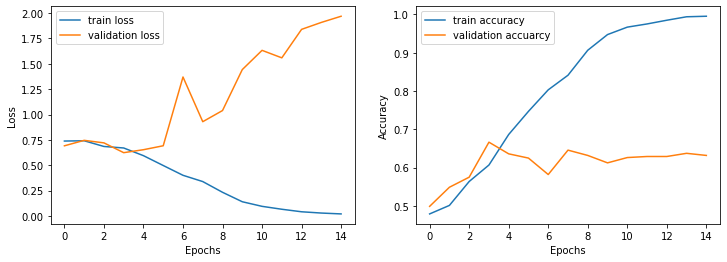

In [ ]:
pickle.dump(history.history, open(path_to_models + bert_model_name + "modified_text_history.pickle", "wb" ))
metrics_history = pickle.load(open(path_to_models + bert_model_name + "modified_text_history.pickle", "rb" ))

fig = plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(metrics_history['loss'], label='train loss')
plt.plot(metrics_history['val_loss'], label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(metrics_history['binary_accuracy'], label='train accuracy')
plt.plot(metrics_history['val_binary_accuracy'], label='validation accuarcy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### On the dataset with the original text

We implement the same previous steps but using the original text.

In [ ]:
# Train, validation, test split
train_split = 0.7
val_split = 0.2
test_split = 1 - train_split - val_split

X = list(data['text_with_punctuation'])
y = list((data['gender'] == 'F').astype('int'))

# Train val test split with modified text
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_split, random_state = 32)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = test_split/(test_split + val_split), random_state = 32) 

In [ ]:
# Transform to tf.data.Dataset
training_df = pd.DataFrame({'text': X_train, 'label': y_train})
train_ds = tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(training_df['text'].values, tf.string),
            tf.cast(training_df['label'].values, tf.int32)
        )
    )
train_ds = train_ds.shuffle(5000).batch(32)

validation_df = pd.DataFrame({'text': X_val, 'label': y_val})
val_ds = tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(validation_df['text'].values, tf.string),
            tf.cast(validation_df['label'].values, tf.int32)
        )
    )
val_ds = val_ds.shuffle(5000).batch(32)


test_df = pd.DataFrame({'text': X_test, 'label': y_test})
test_ds = tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(test_df['text'].values, tf.string),
            tf.cast(test_df['label'].values, tf.int32)
        )
    )
test_ds = test_ds.shuffle(5000).batch(32)

In [ ]:
# Example

for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ')

Review: b"You have leave to try. And how will you make him keep it? Your son is an unprincipled, spoiled, conceited brat. I'm not surprised. Money seems to be more important to him than loyalty or friendship. He has sold himself to Vienna. Let Vienna look out for him. Hardly. No! I won't have him back. Then try harder, Mozart. I have no intention of dismissing you. You will remain in my service and learn your place. Go now. I wish you to return immediately to Salzburg. Your father is waiting for you there patiently. I will speak to you further when I come. How much provocation am I to endure from you? The more license I allow you, the more you take. Why do I have to be humiliated in front of my guests by one of my own servants?"
Label : 0 
Review: b"When I ask questions, I like to hear answers. Suppose I take a look. And you're all alone. I suppose that's your wagon in the river. Even women? What's the matter restless? I saw your fire and dropped by to say hello. How far up the trail? 

#### BERT preprocessing

In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

#### BERT model

In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

classifier_model = build_classifier_model()

In [ ]:
# Loss and evaluation metrics
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

# Callbacks
mc = tf.keras.callbacks.ModelCheckpoint(path_to_models + bert_model_name + 'original_text.h5', monitor='val_loss', mode='min', save_best_only=True, verbose = 0)

# Hyperparameters
epochs = 15
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)
init_lr = 3e-5

# Optimizer
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

# Compile the model
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
# Train
start_time = time.time()
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x = train_ds,
                               validation_data = val_ds,
                               epochs = epochs,
                               callbacks = [mc])
print('Execution time: ', (time.time() - start_time) / 60, 'minutes')

Training model with https://tfhub.dev/google/experts/bert/wiki_books/2
Epoch 1/15
46/46 [==============================] - 66s 1s/step - loss: 0.7144 - binary_accuracy: 0.5066 - val_loss: 0.7171 - val_binary_accuracy: 0.6053
Epoch 2/15
46/46 [==============================] - 47s 1s/step - loss: 0.6798 - binary_accuracy: 0.5815 - val_loss: 0.6695 - val_binary_accuracy: 0.6371
Epoch 3/15
46/46 [==============================] - 40s 870ms/step - loss: 0.6028 - binary_accuracy: 0.6641 - val_loss: 0.6177 - val_binary_accuracy: 0.6537
Epoch 4/15
46/46 [==============================] - 35s 757ms/step - loss: 0.5109 - binary_accuracy: 0.7412 - val_loss: 0.6629 - val_binary_accuracy: 0.6704
Epoch 5/15
46/46 [==============================] - 33s 709ms/step - loss: 0.3868 - binary_accuracy: 0.8168 - val_loss: 0.8405 - val_binary_accuracy: 0.6302
Epoch 6/15
46/46 [==============================] - 33s 711ms/step - loss: 0.2998 - binary_accuracy: 0.8619 - val_loss: 1.2189 - val_binary_accuracy: 

In [ ]:
saved_model = tf.keras.models.load_model(path_to_models + bert_model_name + 'original_text.h5', custom_objects={'KerasLayer':hub.KerasLayer, 'AdamWeightDecay': optimizer})
loss, accuracy = saved_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

8/8 [==============================] - 3s 244ms/step - loss: 0.6375 - binary_accuracy: 0.6556
Loss: 0.6374828815460205
Accuracy: 0.6556016802787781


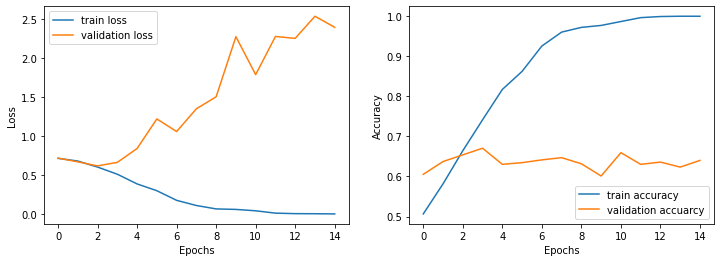

In [ ]:
pickle.dump(history.history, open(path_to_models + bert_model_name + "original_text_history.pickle", "wb" ))
metrics_history = pickle.load(open(path_to_models + bert_model_name + "original_text_history.pickle", "rb" ))

fig = plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(metrics_history['loss'], label='train loss')
plt.plot(metrics_history['val_loss'], label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(metrics_history['binary_accuracy'], label='train accuracy')
plt.plot(metrics_history['val_binary_accuracy'], label='validation accuarcy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()